# Experiment

## All-in-one processor

This file defines a neural network that processes several specrums at once. It does so by treating each spectrum the same as another image "channel." In other words, it stacks the specrum layers and processes each example as a multi-channel image.

In this experiment we are processing 5 different channels: Visual red, visual green, visual blue, altitude data, and night-time near-IR data (city lights). The data was collected and saved as a TFRecord previously in the Data Aquisition chapter.

In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

# Math Stuff
import scipy.misc, random, os
import numpy as np

# Google Earth Engine
import ee
from gee_library import *
ee.Initialize()

# debug stuff
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Threads
import time, Queue
from tqdm import trange
from threading import Thread

# Tensorflow
import tensorflow as tf

from google.protobuf.internal import api_implementation
print(api_implementation._default_implementation_type)


cpp


# Globals

In [2]:
DATA_DIR="data/experiment"
TEST_PROTO_FILENAME = os.path.join(DATA_DIR,"multi_spectrum_test.tfrecords")
TRAIN_PROTO_FILENAME = os.path.join(DATA_DIR,"multi_spectrum_train.tfrecords")

## Data Processing

The `get_batch()` function reads from the TFRecord file we created before and extracts a batch of examples. So that we don't have to rewrite it for other experiments, it delivers each channel separatly. We will stack the channels later. 

This function is hard-coded for the spectrums used in this experiment to maximize readibility.

In [3]:
def get_batch(proto_filename, batch_size):

    NUMBER_OF_CLASSES=3
    
    filename_queue = tf.train.string_input_producer([proto_filename], num_epochs=None)
    proto_reader = tf.TFRecordReader()

    # get an example from file
    _, serialized_example = proto_reader.read(filename_queue)

    # unpack it
    features = tf.parse_single_example(
        serialized_example,
        features={
            # We know the length of both fields. If not the
            # tf.VarLenFeature could be used
            'label': tf.FixedLenFeature([], tf.int64),
            'R': tf.FixedLenFeature([50*50], tf.int64),
            'G': tf.FixedLenFeature([50*50], tf.int64),
            'B': tf.FixedLenFeature([50*50], tf.int64),
            'elevation': tf.FixedLenFeature([50*50], tf.int64),
            'nightlights': tf.FixedLenFeature([50*50], tf.int64),
        })

    # now we have the raw data. Wrangle it into the right dimentions
    R = tf.divide(tf.cast(features['R'], tf.float32), 255)
    G = tf.divide(tf.cast(features['G'], tf.float32), 255)
    B = tf.divide(tf.cast(features['B'], tf.float32), 255)
    elevation = tf.divide(tf.cast(features['elevation'], tf.float32), 255)
    nightlights = tf.divide(tf.cast(features['nightlights'], tf.float32), 255)
    
    # The label is an integer; convert it to a one-hot array
    label = tf.one_hot(features['label'], NUMBER_OF_CLASSES)

    # and batch it
    R_batch, G_batch, B_batch, elevation_batch, nightlight_batch, labels_batch = tf.train.shuffle_batch(
        [R, G, B, elevation, nightlights, label],
        batch_size=batch_size,
        capacity=2000,
        min_after_dequeue=1000)

    return R_batch, G_batch, B_batch, elevation_batch, nightlight_batch, labels_batch

## Network Definition

Now we will define the all-in-one neural network. Remember, by "all-in-one" we mean that we stack the channels before feeding them into a single network.

In [ ]:
#
# Required input placeholders
#
training = tf.placeholder(dtype=tf.bool, name="is_training") # True if training, False if testing
batch_size = tf.placeholder(dtype=tf.int32, name="batch_size")


#
# Load the correct training/test data
#

# Define variables for both the traning and test batches. We will only use one of them per iteration, though.
R_train_batch, G_train_batch, B_train_batch, elevation_train_batch, nightlight_train_batch, labels_train_batch = get_batch(TRAIN_PROTO_FILENAME, batch_size)
R_test_batch, G_test_batch, B_test_batch, elevation_test_batch, nightlight_test_batch, labels_test_batch = get_batch(TRAIN_PROTO_FILENAME, batch_size)

# Use a conditional tensor to select between using the test and training data
R_batch, G_batch, B_batch, elevation_batch, nightlight_batch, labels_batch = tf.cond(training,
                         lambda: (R_train_batch, G_train_batch, B_train_batch, elevation_train_batch, nightlight_train_batch, labels_train_batch), # training==True
                         lambda: (R_test_batch,  G_test_batch,  B_test_batch,  elevation_test_batch,  nightlight_test_batch,  labels_test_batch)# training==False
                        )



#
# Model
#

# Here's where we stack the channels to create a 50x50x5 pixel example batch.
x = tf.stack(values=[R_batch, G_batch, B_batch, elevation_batch, nightlight_batch],
             axis=2)
y_ = labels_batch

# Batch Normalization
input_norm = tf.contrib.layers.batch_norm(x, 
                                  center=True, scale=True, 
                                  is_training=training)



# Resize the data from 2500 element vectors to 2D images.
input_layer = tf.reshape(input_norm, [-1, 50, 50, 5])


#
# Convolution and Pooling Layers
#

# Convolutional Layer #1
conv1 = tf.layers.conv2d(
    inputs=input_layer,
    filters=32,
    kernel_size=[3, 3],
    padding="valid",
    activation=tf.nn.relu)

# Pooling Layer #1
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
# pool1_norm = tf.contrib.layers.batch_norm(pool1, center=True, scale=True, activation=tf.nn.relu, is_training=training)

# Convolutional Layer #2 and Pooling Layer #2
conv2 = tf.layers.conv2d(
    inputs=pool1,
    filters=64,
    kernel_size=[3, 3],
    padding="valid",
    activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
# pool2_norm = tf.contrib.layers.batch_norm(pool2, center=True, scale=True, activation=tf.nn.relu, is_training=training)

# Convolutional Layer #3 (no pooling)
conv3 = tf.layers.conv2d(
    inputs=pool2,
    filters=64,
    kernel_size=[3, 3],
    padding="valid",
    activation=tf.nn.relu)
# conv3_norm = tf.contrib.layers.batch_norm(conv3, center=True, scale=True, activation=tf.nn.relu, is_training=training)


#
# Fully Connected Layers
#


# Dense Layer
conv3_flat = tf.reshape(conv3, [-1, 9 * 9 * 64])
fc1 = tf.layers.dense(inputs=conv3_flat, units=1024, activation=tf.nn.relu)
# fc1_norm = tf.contrib.layers.batch_norm(fc1, center=True, scale=True, activation=tf.nn.relu, is_training=training)
dropout = tf.layers.dropout(
    inputs=fc1,
    rate=0.6,
    training= True)

# Model Output. This will be a one-hot array.
y = tf.layers.dense(inputs=dropout, units=3)



#
# Loss
#

loss = None
train_op = None

loss = tf.losses.softmax_cross_entropy(
    onehot_labels=y_, # ground truth
    logits=y) # network output


#
# Accuracy Output; helpful for observing performance
# 

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
model_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

(50, 50)
Label: [[ 1.  0.  0.]]


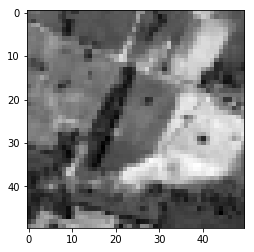

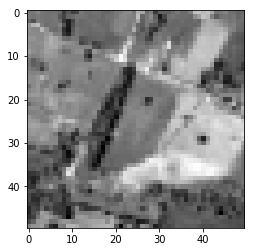

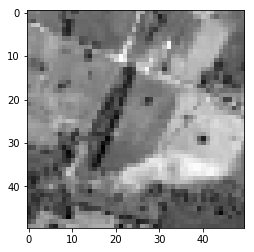

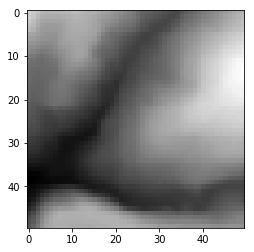

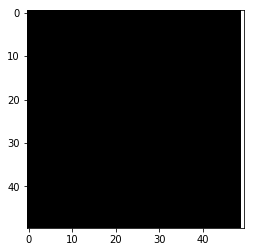

1
2
3
4


In [5]:
#
# Before we get started, let's make sure our network is loading the images correctly.
#


# Initialize tensorflow
coord = tf.train.Coordinator()
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# start the data reader tensors
runner_threads = tf.train.start_queue_runners(sess=sess, coord=coord)

X, L = sess.run( fetches = [input_layer, labels_batch],
                                 feed_dict={training: False, batch_size:1})
R = X[0, :,:,0]
G = X[0, :,:,1]
B = X[0, :,:,2]
E = X[0, :,:,3]
N = X[0, :,:,4]

print R.shape

print "Label:", L
plt.imshow(R, cmap='gray'); plt.show()
plt.imshow(G, cmap='gray'); plt.show()
plt.imshow(B, cmap='gray'); plt.show()
plt.imshow(E, cmap='gray'); plt.show()
plt.imshow(N, cmap='gray'); plt.show()


# Gracefully shut down the neural network
coord.request_stop()
coord.join(runner_threads)
sess.close()

In [6]:
#
# Train
#

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # Required for batch norm
with tf.control_dependencies(update_ops): # Required for batch norm
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 1e-5
    learning_rate = tf.train.exponential_decay(learning_rate = starter_learning_rate,
                                               global_step = global_step,
                                               decay_steps = 200,
                                               decay_rate = 0.96,
                                               staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)


# Initialize TensorFlow
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# start the data reader tensors
tf.train.start_queue_runners(sess=sess)

# And run 20k iterations
for i in range(12000):
    if i%100 == 0:
        train_accuracy, loss_out, lr = sess.run( fetches = [model_accuracy, loss, learning_rate],
                                                 feed_dict={training: False, batch_size:128})
        print "Step", i, "Loss:", loss_out, "Accuracy:", train_accuracy, "LR:", lr
        
    # run an iteration
    optimizer.run(feed_dict={batch_size:128,
                             training: True})


ok
Step 0 Loss: 1.12332 Accuracy: 0.210938 LR: 1e-05
Step 100 Loss: 0.696008 Accuracy: 0.75 LR: 1e-05
Step 200 Loss: 0.759304 Accuracy: 0.5 LR: 9.6e-06
Step 300 Loss: 0.647574 Accuracy: 0.71875 LR: 9.6e-06
Step 400 Loss: 0.673435 Accuracy: 0.625 LR: 9.216e-06
Step 500 Loss: 0.676003 Accuracy: 0.65625 LR: 9.216e-06
Step 600 Loss: 0.609087 Accuracy: 0.71875 LR: 8.84736e-06
Step 700 Loss: 0.772669 Accuracy: 0.601562 LR: 8.84736e-06
Step 800 Loss: 0.587268 Accuracy: 0.773438 LR: 8.49346e-06
Step 900 Loss: 0.577429 Accuracy: 0.71875 LR: 8.49346e-06
Step 1000 Loss: 0.678001 Accuracy: 0.609375 LR: 8.15373e-06
Step 1100 Loss: 0.653722 Accuracy: 0.6875 LR: 8.15373e-06
Step 1200 Loss: 0.595845 Accuracy: 0.742188 LR: 7.82758e-06
Step 1300 Loss: 0.650521 Accuracy: 0.695312 LR: 7.82758e-06
Step 1400 Loss: 0.639973 Accuracy: 0.65625 LR: 7.51447e-06
Step 1500 Loss: 0.508867 Accuracy: 0.820312 LR: 7.51447e-06
Step 1600 Loss: 0.632381 Accuracy: 0.710938 LR: 7.21389e-06
Step 1700 Loss: 0.62423 Accuracy:

KeyboardInterrupt: 

In [ ]:
#
# Evaluate
#


train_accuracy = sess.run( fetches = [model_accuracy],
                           feed_dict={training: False, batch_size:128})


print "Accuracy in the test set:", train_accuracy